*Want to follow along? {nb-download}`Download this notebook.<rotated_planar_quantum_memory_plots.ipynb>`*

In [1]:
from deltakit_circuit import Circuit, measurement_noise_profile  # noqa: I002
from deltakit_circuit.gates import CX, MZ, RZ, H, OneQubitResetGate, PauliBasis
from deltakit_circuit.noise_channels import Depolarise1, Depolarise2, PauliXError

In [2]:
from deltakit_explorer.codes import css_code_memory_circuit, RotatedPlanarCode
from deltakit_explorer.qpu import QPU, NativeGateSet, NoiseParameters

In [3]:
from deltakit_decode import PyMatchingDecoder

In [4]:
from deltakit_decode.analysis import RunAllAnalysisEngine, StimDecoderManager

To handle our filesystem, data and parallelisation options, we also need some external packages:

In [5]:
import os
from itertools import groupby
from operator import itemgetter
from typing import Tuple

import numpy as np
import pandas as pd

We can now start defining our experiment parameters.

In [6]:
# This value determines the maximum number of samples to take from the circuit.
# A higher number of shots will provide a more accurate value of the
# logical error rate.
max_shots = 1e7

# File name to save output data.
filename = f"RPC_MWPM_X_MEM_{max_shots:.0e}_shots.csv"

As mentioned, we will be performing a logical-X quantum memory experiment. Before running the experiment, we will create some convenience functions to streamline the experiment implementation.

The first of these is `rotated_planar_xmem_noiseless` which will create a rotated planar code object and a noiseless quantum memory circuit. This circuit is hard-coded to be in the logical-X basis and in Code Explorer's default gate set. This circuit can be inspected by using `print`.

In [7]:
def rotated_planar_xmem_noiseless(
    x_distance: int, z_distance: int, num_rounds: int
) -> Tuple[RotatedPlanarCode, Circuit]:
    """This function takes as input quantum memory parameters (X-distance, Z-distance, Num Rounds)
    and returns a noiseless logical-X quantum memory circuit in a default gate set.

    Parameters
    ----------
    x_distance : int
        X error distance for code.
    z_distance : int
        Z error distance for code.
    num_rounds : int
        Number of rounds of syndrome extraction.

    Returns
    -------
    Tuple[RotatedPlanarCode, Circuit]
        A tuple of the code object, and a stimple Circuit object describing the quantum memory experiment.
    """

    # Create the code object.
    code = RotatedPlanarCode(width=x_distance, height=z_distance)

    # Generate a noiseless quantum memory circuit in the correct logical basis.
    memory_circuit = css_code_memory_circuit(
        css_code=code, num_rounds=num_rounds, logical_basis=PauliBasis.X
    )

    return code, memory_circuit

The function `noise_model` will create the noise model outlined in the Paler paper above, and takes as input the physical qubit error rate.

In [8]:
def noise_model(physical_error_rate: float) -> NoiseParameters:
    """This function takes as input a single parameter: the physical noise rate (p) of our noise model.
    It creates the same noise model as outlined in the paper https://arxiv.org/abs/2205.09828 and returns
    the relevant NoiseParameters object.

    Parameters
    ----------
    physical_error_rate : float
        Single parameter describing the noise of physical qubits.

    Returns
    -------
    NoiseParameters
        An object that contains all information about the noise model.
    """

    # Single- and two-qubit gates are affected by unbiased depolarising
    # noise channels of the same strength.
    gate_noise = [
        lambda noise_context: Depolarise1.generator_from_prob(physical_error_rate)(
            noise_context.gate_layer_qubits(H)
        ),
        lambda noise_context: Depolarise2.generator_from_prob(physical_error_rate)(
            noise_context.gate_layer_qubits(CX)
        ),
    ]

    # On resetting a physical qubit (in the Z-basis) we
    # prepare an orthogonal state with probability p.
    reset_noise = [
        lambda noise_context: PauliXError.generator_from_prob(physical_error_rate)(
            noise_context.gate_layer_qubits(OneQubitResetGate)
        )
    ]

    # Measurements outcomes are incorrectly recorded with probability physical_error_rate.
    measurement_flip_noise = measurement_noise_profile(physical_error_rate)

    # Idle qubits are affected by unbiased depolarising noise channels.
    def idle_noise(qubit, _t):
        return Depolarise1(qubit=qubit, probability=physical_error_rate)

    # Construct noise model
    noise_model = NoiseParameters(
        gate_noise=gate_noise,
        reset_noise=reset_noise,
        idle_noise=idle_noise,
        measurement_flip=measurement_flip_noise,
    )

    return noise_model

Here, the `rotated_planar_xmem_noisy` function will create a _noisy_ quantum memory circuit, using the relevant noise model and a (hard-coded) gate set. 
This function uses the `rotated_planar_xmem_noiseless` function to create the relevant code object and noiseless circuit, 
and then compiles the noiseless circuit into the correct gate set with the input noise model. 

This is the circuit we will be sampling from to get a logical error rate.

In [9]:
def rotated_planar_xmem_noisy(
    x_distance: int, z_distance: int, num_rounds: int, noise_model: NoiseParameters
) -> Circuit:
    """This function uses similar inputs to `rotated_planar_xmem_noiseless`, with the addition of a noise model.
    It also has a restricted gate set hardcoded in, to match the gate set used in the paper.


    Parameters
    ----------
    x_distance : int
        X error distance for code.
    z_distance : int
        Z error distance for code.
    num_rounds : int
        Number of rounds of syndrome extraction.
    noise_model : NoiseParameters
        The noise model to consider.

    Returns
    -------
    Circuit
        A stimple circuit object describing a noisy quantum memory experiment.
    """

    # Get code object and the noiseless circuit
    code, noiseless_circuit = rotated_planar_xmem_noiseless(
        x_distance=x_distance, z_distance=z_distance, num_rounds=num_rounds
    )

    # Restrict the gate set
    gate_set = NativeGateSet(
        one_qubit_gates={H},
        two_qubit_gates={CX},
        measurement_gates={MZ},
        reset_gates={RZ},
    )

    # Create a QPU object using
    #   - the qubits defined by the code
    #   - the noise model
    #   - the gate set
    qpu = QPU(
        qubits=code.qubits, noise_model=noise_model, native_gates_and_times=gate_set
    )

    # Create a noisy circuit by compiling the noiseless circuit in the QPU
    noisy_circuit = qpu.compile_and_add_noise_to_circuit(noiseless_circuit)

    return noisy_circuit

We will be using the MWPM decoder implemented in the `pymatching` python package. We have defined a function to construct the decoder and wrap it into a decoder manager. Given an input circuit, the decoder manager has methods to run many samples of errors through the decoder and give an approximate value of the logical error rate.

In [10]:
def experiment_decoder_manager(
    x_distance: int, z_distance: int, num_rounds: int, physical_error_rate: float
) -> StimDecoderManager:
    """This function will combine all previous functions to return a single value: the logical error rate.

    Parameters
    ----------
    x_distance : int
        X error distance for code.
    z_distance : int
        Z error distance for code.
    num_rounds : int
        Number of rounds of syndrome extraction.
    physical_error_rate : float
        Single parameter describing the noise of each physical qubit.

    Returns
    -------
    float
        The logical error rate for this code instance.

    """

    # Get the noise profile
    noise_profile = noise_model(physical_error_rate=physical_error_rate)

    # Create the noisy circuit given code parameters
    noisy_circuit = rotated_planar_xmem_noisy(
        x_distance=x_distance,
        z_distance=z_distance,
        num_rounds=num_rounds,
        noise_model=noise_profile,
    )

    # Create the decoder
    decoder, stim_circuit = PyMatchingDecoder.construct_decoder_and_stim_circuit(
        noisy_circuit
    )

    # Return the decoder manager
    return StimDecoderManager(
        stim_circuit,
        decoder,
        metadata={
            "Code": "rotated_planar_code",
            "QPU": "basic_qpu",
            "Basis": PauliBasis.X.name,
            "X Distance": x_distance,
            "Z Distance": z_distance,
            "Num Rounds": num_rounds,
            "Physical Error": physical_error_rate,
        },
    )

We can run a simple experiment to see the output of this function:

In [11]:
pct1_shots, pct1_fails = experiment_decoder_manager(
    x_distance=3, z_distance=3, num_rounds=3, physical_error_rate=0.01
).run_batch_shots(1e5)
pt1pct1_shots, pt1pct1_fails = experiment_decoder_manager(
    x_distance=3, z_distance=3, num_rounds=3, physical_error_rate=0.001
).run_batch_shots(1e5)
print(f"Logical error rate with physical error 1%: {pct1_fails/pct1_shots}")
print(f"Logical error rate with physical error .1%: {pt1pct1_fails/pt1pct1_shots}")

Logical error rate with physical error 1%: 0.15454
Logical error rate with physical error .1%: 0.00275


We are now ready to run an experiment seeking to replicate the results in the paper mentioned above. 
We are aiming to recreate some of Fig. 6, which shows (in dark green) the rotated planar code being decoded by MWPM for:
- distances 3, 5, 7, 9
- physical error rates ranging from `1e-5` to `~1e-2`

We define these parameters below.

As this simulation can be computationally heavy, we will be writing data to a CSV file.

Furthermore, to reduce runtime at higher physical error rates, the number of samples per data point will be defined as: 
`int(min(max_shots, physical_error_rate**-2))`

In [12]:
distances = [3, 5, 7, 9]
physical_error_rates = np.logspace(-5, -1.75, 14)

This following cell will run the experiment, and with the default parameters takes approximately 45minutes on a 2019 MacBook Pro with Intel i7 and 16GB DDR4 RAM.

If `overwrite_data` is set to `False`, if a CSV exists it will be loaded and the experiment will not run. 
If set to `True`, an existing CSV will be removed and a new one created. 

We have provided a pre-made CSV `RPC_MWPM_X_MEM_1e7_shots.csv` which can be loaded straight in, without running this cell. 

In [13]:
overwrite_data = False
# overwrite_data = True
if overwrite_data and os.path.exists(filename):
    os.remove(filename)

if overwrite_data or not os.path.exists(filename):
    # Make all the decoder managers for the different data-points
    decoder_managers = []
    for phys in physical_error_rates:
        num_shots = int(min(phys**-2, max_shots))
        decoder_managers.extend(
            (num_shots, experiment_decoder_manager(distance, distance, distance, phys))
            for distance in distances
        )

    # Aggregate managers into run engines for multiprocessing
    data_frames = [
        RunAllAnalysisEngine(
            experiment_name = f"experiment_{num_shots}_{phys}",
            decoder_managers = [manager for _, manager in manager_groups],
            max_shots = num_shots
        ).run()
        for num_shots, manager_groups in groupby(decoder_managers, key=itemgetter(0))
    ]
    pd.concat(data_frames).to_csv(filename, index=False)

Evaluating codes: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.81s/it]


Now that the experiment has completed, we can plot the results. 

Importantly, we have calculated the total logical error rate given a $d$-distance code and $d$ rounds of quantum error correction. 
The work from Paler plots a _per round_ logical error rate, and so we divide our outcomes by the number of QEC rounds to achieve
a per round logical error rate. More information can be found in the documentation. 

In [14]:
import matplotlib.pyplot as plt

data = pd.read_csv(filename)
colors = {3: "blue", 5: "green", 7: "orange", 9: "red"}


def plot_per_round_logical_error(distance: int) -> None:
    """Plot the logical error rate of a single distance value,
    with data taken from the results CSV.

    Parameters
    ----------
    distance : int
        Which distance value to plot the logical error rate of.
    """
    subframe = data[(data["Num Rounds"] == distance)].sort_values(by=["Physical Error"])

    logical_rates_per_round = subframe["fails"] / subframe["shots"] / distance
    physical_error = subframe["Physical Error"]
    plt.plot(
        physical_error,
        logical_rates_per_round,
        label=f"{filename.replace('.csv', '')} d={distance}",
        markersize=7,
        marker="o",
        linestyle="-",
        color=colors[distance],
    )

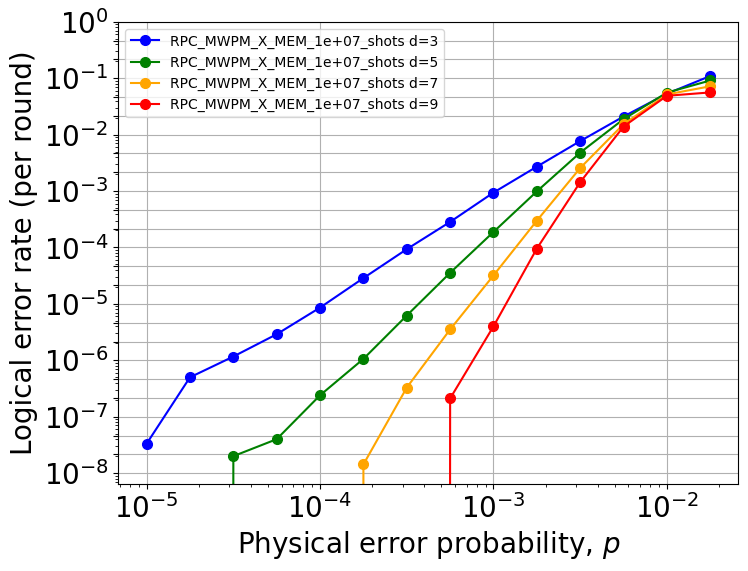

In [15]:
plt.figure(figsize=(8, 6))
plt.yscale("log")
plt.xscale("log")

for distance in distances:
    plot_per_round_logical_error(distance=distance)

plt.xticks([1e-2, 1e-3, 1e-4, 1e-5], fontsize=20)
plt.yticks([10 ** (-i / 3) for i in range(25)], fontsize=20)

plt.xlabel("Physical error probability, $p$", fontsize=20)
plt.ylabel("Logical error rate (per round)", fontsize=20)
plt.grid()
plt.legend()